## 1. Installation des dépendances

In [3]:
# Import des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import os
from keras import layers
from keras.models import Model
from huggingface_hub import from_pretrained_keras
import cv2
from PIL import Image
import glob
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
import time
from skimage.metrics import structural_similarity as ssim
import shutil
from pathlib import Path
from keras.applications import VGG19
from keras.models import Model
from keras import backend as K
import tensorflow as tf

## Remettre la ligne pour utiliser le backend Jax et tester si ca marche de nouveau
os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppression des avertissements de TensorFlow

print("Versions des bibliothèques:")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")


Versions des bibliothèques:
TensorFlow: 2.19.0
Keras: 3.9.0


## 2. Chargement et préparation des données

In [18]:
# Configuration des paramètres globaux

NOISE_LEVEL = 0.01     # Niveau de bruit global (0.05 = très faible, 0.1 = faible, 0.2 = moyen, 0.5 = fort, 1-2 : très fort)
NOISE_TYPE = "gaussian"  # Type de bruit: "gaussian", "salt_pepper", ou "speckle"
IMAGE_SIZE = 256      # Taille des images
BATCH_SIZE = 16       # Taille du batch
SEED = 42            # Seed pour la reproducibilité


np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Définir les chemins d'accès
WINDOWS_DIR = '/mnt/c/Users/NyveK/Downloads/Dataset Livrable 2/Dataset'
TARGET_WSL_DIR = '/home/kevin/datasets/livrable2/raw'
TARGET_PROCESSED_DIR = '/home/kevin/datasets/livrable2/processed'

# Vérifier si le chemin Windows existe
windows_exists = os.path.exists(WINDOWS_DIR)
print(f"Le chemin Windows existe: {windows_exists}")

# Créer les dossiers de destination s'ils n'existent pas
Path(TARGET_WSL_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

# Copier les données uniquement si le chemin source existe
if windows_exists:
    print(f"Copie des données depuis {WINDOWS_DIR} vers {TARGET_WSL_DIR}...")
    try:
        shutil.copytree(WINDOWS_DIR, TARGET_WSL_DIR, dirs_exist_ok=True)
        print("Copie terminée avec succès!")
    except Exception as e:
        print(f"Erreur lors de la copie: {e}")
else:
    print(f"ATTENTION: Le chemin source {WINDOWS_DIR} n'existe pas!")
    print("Veuillez vérifier le chemin et le monter correctement dans WSL.")
    print("Utilisation du chemin WSL directement s'il existe déjà...")

# Utiliser TARGET_WSL_DIR comme chemin de base s'il existe et contient des données
BASE_DIR = TARGET_WSL_DIR if os.path.exists(TARGET_WSL_DIR) and os.listdir(TARGET_WSL_DIR) else None

# Avertir l'utilisateur si aucun chemin valide n'est trouvé
if BASE_DIR is None:
    print("Aucun chemin valide trouvé pour les données. Le code utilisera des données de démonstration.")


print(f"Configuration : NOISE_LEVEL={NOISE_LEVEL}, NOISE_TYPE={NOISE_TYPE}, IMAGE_SIZE={IMAGE_SIZE}x{IMAGE_SIZE}")

Le chemin Windows existe: True
Copie des données depuis /mnt/c/Users/NyveK/Downloads/Dataset Livrable 2/Dataset vers /home/kevin/datasets/livrable2/raw...
Copie terminée avec succès!
Configuration : NOISE_LEVEL=0.01, NOISE_TYPE=gaussian, IMAGE_SIZE=256x256


In [19]:
def explore_dataset(base_dir):
    """Explore le dataset et affiche des statistiques sur les classes."""
    if base_dir is None or not os.path.exists(base_dir):
        print("Chemin de données invalide. Impossible d'explorer le dataset.")
        return None, {}
    
    print(f"Exploration du dataset dans {base_dir}")
    
    # Vérifier si le dataset est organisé par classes ou contient directement des images
    items = os.listdir(base_dir)
    potential_classes = [c for c in items if os.path.isdir(os.path.join(base_dir, c))]
    
    # Si nous avons des sous-dossiers, les considérer comme des classes
    if potential_classes:
        classes = potential_classes
        print(f"Dataset organisé par classes. Classes trouvées: {classes}")
        
        class_stats = {}
        total_images = 0
        
        fig, axes = plt.subplots(1, len(classes), figsize=(20, 4))
        if len(classes) == 1:
            axes = [axes]  # Convertir en liste pour indexation uniforme
        
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(base_dir, class_name)
            images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
            num_images = len(images)
            total_images += num_images
            class_stats[class_name] = num_images
            
            # Afficher un exemple d'image pour chaque classe
            if num_images > 0:
                sample_img_path = os.path.join(class_dir, images[0])
                try:
                    img = plt.imread(sample_img_path)
                    axes[i].imshow(img)
                    axes[i].set_title(f"{class_name}: {num_images} images")
                except Exception as e:
                    print(f"Erreur lors de l'affichage de {sample_img_path}: {e}")
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\nStatistiques par classe:")
        for class_name, count in class_stats.items():
            print(f"{class_name}: {count} images ({count / total_images * 100:.1f}%)")
        
        print(f"\nTotal des images: {total_images}")
        
        return classes, class_stats
    
    # Sinon, considérer que toutes les images sont dans le répertoire de base
    else:
        images = [f for f in items if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        num_images = len(images)
        
        if num_images > 0:
            print(f"Dataset sans classes. {num_images} images trouvées.")
            
            # Afficher quelques exemples
            fig, axes = plt.subplots(1, min(5, num_images), figsize=(20, 4))
            if num_images == 1:
                axes = [axes]
            
            for i in range(min(5, num_images)):
                sample_img_path = os.path.join(base_dir, images[i])
                try:
                    img = plt.imread(sample_img_path)
                    axes[i].imshow(img)
                    axes[i].set_title(f"Image {i+1}")
                except Exception as e:
                    print(f"Erreur lors de l'affichage de {sample_img_path}: {e}")
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            return None, {"all": num_images}
        else:
            print("Aucune image trouvée dans le répertoire.")
            return None, {}

# Fonction améliorée pour charger les images
def load_and_prepare_dataset(base_dir, img_size=(256, 256), max_images=None, val_split=0.15, test_split=0.15):
    """
    Charge le dataset, le divise en ensembles d'entraînement/validation/test,
    et prépare les versions bruitées.
    """
    if base_dir is None or not os.path.exists(base_dir):
        print("Chemin de données invalide. Utilisation de CIFAR-10 comme données de démonstration.") # Si le chemin n'existe pas, on charge CIFAR-10 en backup
        return load_demo_dataset(img_size)
    
    # Explorer le dataset pour déterminer sa structure
    classes, _ = explore_dataset(base_dir)
    
    # Initialiser les listes pour les images
    clean_images = []
    image_paths = []
    
    # Si le dataset est organisé par classes
    if classes:
        for class_name in classes:
            class_dir = os.path.join(base_dir, class_name)
            class_images = glob.glob(os.path.join(class_dir, "*.jpg")) + \
                          glob.glob(os.path.join(class_dir, "*.jpeg")) + \
                          glob.glob(os.path.join(class_dir, "*.png")) + \
                          glob.glob(os.path.join(class_dir, "*.bmp"))
            image_paths.extend(class_images)
    # Sinon, charger directement depuis le répertoire de base
    else:
        image_paths = glob.glob(os.path.join(base_dir, "*.jpg")) + \
                     glob.glob(os.path.join(base_dir, "*.jpeg")) + \
                     glob.glob(os.path.join(base_dir, "*.png")) + \
                     glob.glob(os.path.join(base_dir, "*.bmp"))
    
    # Limiter le nombre d'images si nécessaire
    if max_images and len(image_paths) > max_images:
        random.shuffle(image_paths)
        image_paths = image_paths[:max_images]
    
    print(f"Chargement de {len(image_paths)} images...")
    
    # Charger et prétraiter les images
    for path in tqdm(image_paths):
        try:
            img = Image.open(path).convert("RGB")
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalisation
            clean_images.append(img_array)
        except Exception as e:
            print(f"Erreur lors du chargement de {path}: {e}")
    
    if not clean_images:
        print("Aucune image n'a pu être chargée. Utilisation de CIFAR-10 comme données de démonstration.")
        return load_demo_dataset(img_size)
    
    clean_images = np.array(clean_images)
    
    # Diviser en ensembles d'entraînement/validation/test
    indices = np.arange(len(clean_images))
    np.random.shuffle(indices)
    
    test_size = int(len(indices) * test_split)
    val_size = int(len(indices) * val_split)
    train_size = len(indices) - test_size - val_size
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]
    
    train_clean = clean_images[train_indices]
    val_clean = clean_images[val_indices]
    test_clean = clean_images[test_indices]
    
    # Ajouter du bruit pour créer les versions bruitées
    train_noisy = add_noise(train_clean)
    val_noisy = add_noise(val_clean)
    test_noisy = add_noise(test_clean)
    
    print(f"Dataset préparé: {train_clean.shape[0]} images d'entraînement, " 
          f"{val_clean.shape[0]} images de validation, {test_clean.shape[0]} images de test")
    
    return (train_clean, train_noisy), (val_clean, val_noisy), (test_clean, test_noisy)

# Fonction pour charger CIFAR-10 comme données de démonstration
def load_demo_dataset(img_size=(256, 256)):
    """Charge CIFAR-10 comme dataset de démonstration"""
    print("Chargement d'images CIFAR-10 comme données de démonstration...")
    from keras.datasets import cifar10
    
    (x_train, _), (x_test, _) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Sélectionner un sous-ensemble des images
    train_subset = x_train[:1000]
    val_subset = x_train[1000:1200]
    test_subset = x_test[:200]
    
    # Redimensionner à la taille souhaitée
    train_resized = np.array([cv2.resize(img, img_size) for img in train_subset])
    val_resized = np.array([cv2.resize(img, img_size) for img in val_subset])
    test_resized = np.array([cv2.resize(img, img_size) for img in test_subset])
    
    # Ajouter du bruit
    train_noisy = add_noise(train_resized)
    val_noisy = add_noise(val_resized)
    test_noisy = add_noise(test_resized)
    
    return (train_resized, train_noisy), (val_resized, val_noisy), (test_resized, test_noisy)

# Fonction pour ajouter du bruit (conservée telle quelle)
def add_noise(images, noise_type=NOISE_TYPE, variance=NOISE_LEVEL, amount=NOISE_LEVEL):
    """
    Ajoute du bruit aux images en utilisant le niveau global défini en haut du notebook.
    
    Args:
        images: Images à bruiter
        noise_type: Type de bruit ("gaussian", "salt_pepper", "speckle")
        variance: Variance du bruit gaussien ou speckle (utilise NOISE_LEVEL par défaut)
        amount: Quantité de bruit sel et poivre (utilise NOISE_LEVEL par défaut)
    
    Returns:
        Images bruitées
    """
    noisy_images = []
    
    for img in images:
        if noise_type == "gaussian":
            # Bruit gaussien
            noise = np.random.normal(0, variance**0.5, img.shape)
            noisy_img = img + noise
        elif noise_type == "salt_pepper":
            # Bruit sel et poivre
            noisy_img = img.copy()
            # Sel (pixels blancs)
            salt = np.random.random(img.shape) < amount/2
            noisy_img[salt] = 1.0
            # Poivre (pixels noirs)
            pepper = np.random.random(img.shape) < amount/2
            noisy_img[pepper] = 0.0
        elif noise_type == "speckle":
            # Bruit speckle (multiplicatif)
            noise = np.random.normal(0, variance**0.5, img.shape)
            noisy_img = img + img * noise
        else:
            noisy_img = img
        
        # Limiter les valeurs à [0, 1]
        noisy_img = np.clip(noisy_img, 0, 1)
        noisy_images.append(noisy_img)
    
    return np.array(noisy_images)


# Fonction pour visualiser des exemples d'images (conservée telle quelle)
def display_images(clean_images, noisy_images, num_images=5):
    """Affiche des paires d'images (propre/bruitée)"""
    plt.figure(figsize=(15, 6))
    
    for i in range(min(num_images, len(clean_images))):
        # Image propre
        plt.subplot(2, num_images, i+1)
        plt.imshow(clean_images[i])
        plt.title("Image propre")
        plt.axis('off')
        
        # Image bruitée
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(noisy_images[i])
        plt.title("Image bruitée")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Exploration du dataset dans /home/kevin/datasets/livrable2/raw
Dataset sans classes. 148 images trouvées.


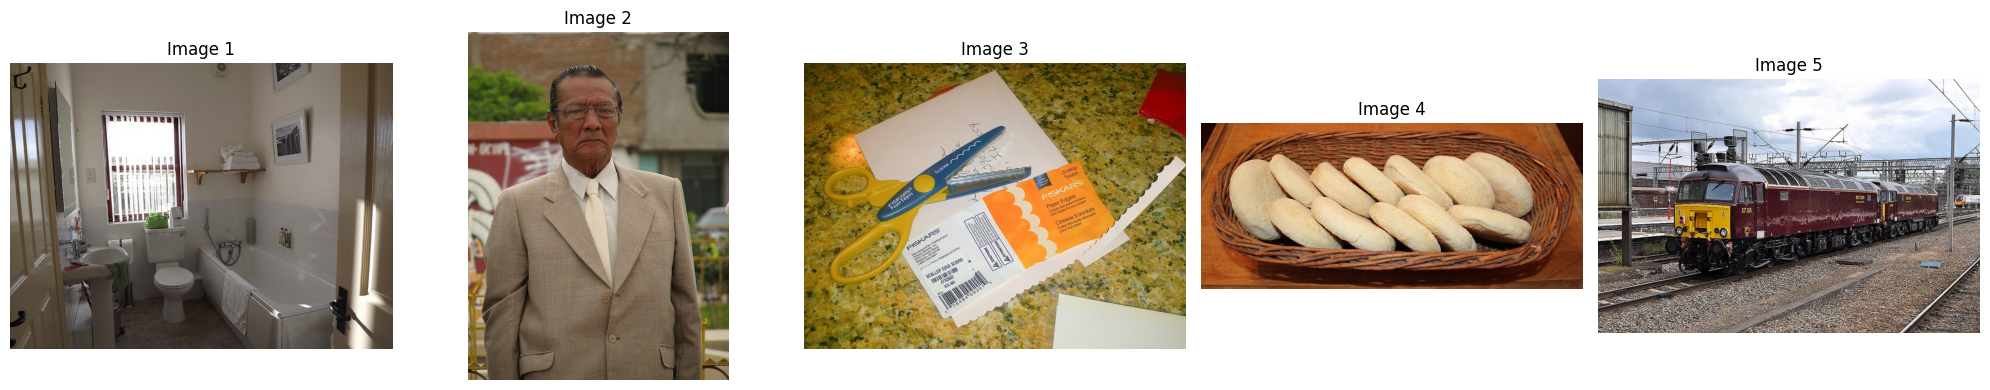

Chargement de 148 images...


  0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
# Charger et préparer le dataset

(train_clean, train_noisy), (val_clean, val_noisy), (test_clean, test_noisy) = load_and_prepare_dataset(
    base_dir=BASE_DIR,
    img_size=(IMAGE_SIZE, IMAGE_SIZE),
    max_images=2000 #Au cas où le dataset est trop grand, on limite à 2000 images
)

# Générateur d’images avec augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Générateur pour les images bruitées/nettoyées
train_generator = datagen.flow(train_noisy, train_clean, batch_size=BATCH_SIZE)

# Visualiser quelques exemples
print("\nVisualisation de quelques exemples d'images propres et bruitées:")
display_images(train_clean, train_noisy)


## 3. Implémentation et entraînement des modèles de débruitage

### 3.0 Définition de la loss function combinee

In [14]:
vgg_model = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg_model.trainable = False
vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block3_conv3').output)


# Fonction de perte perceptuelle avec VGG19
def perceptual_loss(y_true, y_pred):
    # On suppose que les images sont déjà en [0,1], on les upscale pour VGG
    y_true_rescaled = y_true * 255.0
    y_pred_rescaled = y_pred * 255.0
    
    true_features = vgg_feature_extractor(y_true_rescaled)
    pred_features = vgg_feature_extractor(y_pred_rescaled)
    
    return tf.reduce_mean(tf.square(true_features - pred_features))



# SSIM comme fonction de perte
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Combinaison pondérée des pertes
def combined_loss(alpha=0.6, beta=0.2, gamma=0.2):
    def loss(y_true, y_pred):
        l1 = tf.reduce_mean(tf.square(y_true - y_pred))               # MSE
        l2 = ssim_loss(y_true, y_pred)                                # SSIM
        l3 = perceptual_loss(y_true, y_pred)                          # Perceptual
        return alpha * l1 + beta * l2 + gamma * l3
    return loss


I0000 00:00:1744378924.245389    3346 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21123 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6
I0000 00:00:1744378924.560764    3346 cuda_executor.cc:479] failed to allocate 20.63GiB (22149939200 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1744378924.747471    3346 cuda_executor.cc:479] failed to allocate 18.57GiB (19934945280 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1744378924.953884    3346 cuda_executor.cc:479] failed to allocate 16.71GiB (17941450752 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1744378925.167379    3346 cuda_executor.cc:479] failed to allocate 15.04GiB (16147305472 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1744378925.392859   

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 3.1 Auto-encodeur convolutif simple

In [15]:
def build_improved_autoencoder(input_shape=(256, 256, 3)):
    """Construit un auto-encodeur plus profond avec skip connections"""
    input_img = keras.Input(shape=input_shape)
    
    # Encodeur - plus de filtres et plus de couches
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    skip1 = x
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skip2 = x
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skip3 = x
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Décodeur avec skip connections
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Couche finale
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss=combined_loss())
    
    return autoencoder


# Construire et entraîner l'auto-encodeur amélioré
improved_autoencodeur = build_improved_autoencoder()
improved_autoencodeur.summary()

print("Entraînement de l'auto-encodeur amélioré...")
steps_per_epoch = len(train_noisy) // BATCH_SIZE

improved_history = improved_autoencodeur.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(val_noisy, val_clean),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
        keras.callbacks.ModelCheckpoint(filepath='best_model_loss_combine.h5', save_best_only=True)
    ]
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 3,881,219 (14.81 MB)

 Trainable params: 3,878,403 (14.79 MB)

 Non-trainable params: 2,816 (11.00 KB)

Entraînement de l'auto-encodeur amélioré...


/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1744379112.426008    3760 service.cc:152] XLA service 0x7f3808001960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744379112.427912    3760 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-11 15:45:12.960310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-11 15:45:13.405447: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert/Assert
2025-04-11 15:45:13.406718: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_1/Assert
2025-04-11 15:45:13.407488: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_2/Assert
2025-04-11 15:45:13.407860: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:3

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 163306.4219

2025-04-11 15:45:45.237242: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert/Assert
2025-04-11 15:45:45.237461: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_1/Assert
2025-04-11 15:45:45.237627: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_2/Assert
2025-04-11 15:45:45.237709: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_3/Assert


3/6 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - loss: 150583.1875  

2025-04-11 15:46:02.081253: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 200 bytes spill stores, 200 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 200 bytes spill stores, 200 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 123079.7422

2025-04-11 15:46:04.042620: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert/Assert
2025-04-11 15:46:04.043541: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_1/Assert
2025-04-11 15:46:04.044101: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_2/Assert
2025-04-11 15:46:04.044447: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_3/Assert
2025-04-11 15:46:10.805077: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng33{k2=15,k6=0,k13=1,k14=0,k22=0} for conv %cudnn-conv-bias-activation.75 = (f32[22,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,64,256,256]{3,2,1,0} %bitcast.1876, f32[64,64,3,3]{3,2,1,0} %bitcast.1981, f32[64]{0} %bitcast.1983), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_ta

6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - loss: 117808.3516 - val_loss: 52766.2148 - learning_rate: 0.0010
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 51085.9688

/home/kevin/dev/tf217/tf217/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 51085.9688 - val_loss: 49025.3086 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 50274.6328 - val_loss: 50976.6641 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 45746.0000 - val_loss: 53523.8594 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 48227.0938 - val_loss: 55665.3516 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 48045.5352 - val_loss: 55878.1094 - learning_rate: 2.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 48562.5117 - val_loss: 57475.1523 - learning_rate: 2.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 43363.6758 - val_loss: 57707.1641 - learning_rate: 2.0000e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 47962.5586 - val_loss: 58350.2266 - learning_rate: 4.0000e-05


### 3.2 Auto-encodeur avec Feature Pyramids (AEFPNC)

In [31]:
def build_aefpnc(input_shape=(256, 256, 3)):
    """Construit un auto-encodeur avec feature pyramids"""
    # Entrée
    input_img = keras.Input(shape=input_shape)
    
    # Encodeur
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = layers.MaxPooling2D((2, 2), padding='same')(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2), padding='same')(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling2D((2, 2), padding='same')(conv3)
    
    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    
    # Décodeur avec connexions pyramidales
    up1 = layers.UpSampling2D((2, 2))(conv4)
    concat1 = layers.Concatenate()([up1, conv3])
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
    
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.Concatenate()([up2, conv2])
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.Concatenate()([up3, conv1])
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    
    # Couche de sortie
    output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv7)
    
    # Modèle complet
    model = keras.Model(input_img, output)
    model.compile(optimizer='adam', loss=combined_loss())
    
    return model

# Construire et entraîner l'auto-encodeur AEFPNC
aefpnc_autoencoder = build_aefpnc()
aefpnc_autoencoder.summary()

print("Entraînement de l'auto-encodeur AEFPNC...")
steps_per_epoch = len(train_noisy) // BATCH_SIZE
aefpnc_history = aefpnc_autoencoder.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(val_noisy, val_clean),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
        keras.callbacks.ModelCheckpoint(filepath='best_model_aefpnc.h5', save_best_only=True)
    ]
)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 128, 128,  │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ conv2d_42[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_17… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_15    │ (None, 64, 64,    │          0 │ conv2d_43[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 64, 64,    │          0 │ up_sampling2d_15… │
│ (Concatenate)       │ 768)              │            │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_15[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 128, 128,  │          0 │ conv2d_44[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 128, 128,  │          0 │ up_sampling2d_16… │
│ (Concatenate)       │ 384)              │            │ conv2d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 128, 128,  │    442,496 │ concatenate_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_17    │ (None, 256, 256,  │          0 │ conv2d_45[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 256, 256,  │          0 │ up_sampling2d_17… │
│ (Concatenate)       │ 192)              │            │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 256, 256,  │    110,656 │ concatenate_17[0

 Total params: 3,875,587 (14.78 MB)

 Trainable params: 3,875,587 (14.78 MB)

 Non-trainable params: 0 (0.00 B)

Entraînement de l'auto-encodeur AEFPNC...
Epoch 1/50


2025-04-11 14:00:49.664423: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert/Assert
2025-04-11 14:00:49.664613: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_1/Assert
2025-04-11 14:00:49.665207: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_2/Assert
2025-04-11 14:00:49.665268: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_3/Assert


1/6 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 51782.5117

2025-04-11 14:00:52.341727: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert/Assert
2025-04-11 14:00:52.341803: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_1/Assert
2025-04-11 14:00:52.341844: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_2/Assert
2025-04-11 14:00:52.341857: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/SSIM/Assert_3/Assert


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - loss: 54033.4297

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 53637.5820 - val_loss: 43249.2773 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 46342.7266 - val_loss: 43661.5078 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 46627.8086

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - loss: 46700.9297 - val_loss: 42329.6992 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 55748.0117 - val_loss: 42707.3984 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 46495.3672

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - loss: 46647.3828 - val_loss: 41104.1172 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 46075.6211 - val_loss: 41425.8672 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 44669.6016 - val_loss: 41522.9531 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 53105.9727 - val_loss: 41380.3906 - learning_rate: 0.0010
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 48178.8867

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - loss: 47895.3320 - val_loss: 40714.2188 - learning_rate: 2.0000e-04
Epoch 10/50
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 48067.6406 - val_loss: 40835.0938 - learning_rate: 2.0000e-04
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - loss: 48450.0586 - val_loss: 41656.3984 - learning_rate: 2.0000e-04
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 41787.0430 - val_loss: 41691.0000 - learning_rate: 2.0000e-04
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 46663.5547 - val_loss: 41591.8008 - learning_rate: 4.0000e-05
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 51135.1562 - val_loss: 41575.3438 - learning_rate: 4.0000e-05
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - loss: 45329.1641 - val_loss: 41514.0977 - learning_rate: 4.0000e-05
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 46348.2031 - val_loss: 41515.4258 - learning_rate: 8.0000e-06


### 3.3 MAXIM-S3-DENOISING-SIDD (état de l'art)

In [32]:
# # Charger le modèle MAXIM depuis Hugging Face
# from huggingface_hub import snapshot_download

# try:
#     print("Téléchargement du modèle MAXIM-S3-DENOISING-SIDD...")
#     model_dir = snapshot_download("google/maxim-s3-denoising-sidd")
#     print("Chargement du modèle...")
#     maxim_model = tf.saved_model.load(model_dir)
#     maxim_available = True
#     print("Modèle MAXIM chargé avec succès!")
# except Exception as e:
#     print(f"Erreur lors du chargement du modèle MAXIM: {e}")
#     print("Utilisation d'une autre approche pour charger le modèle...")
#     try:
#         maxim_model = from_pretrained_keras("google/maxim-s3-denoising-sidd")
#         maxim_available = True
#         print("Modèle MAXIM chargé avec succès via from_pretrained_keras!")
#     except:
#         print("Impossible de charger le modèle MAXIM. Le test sera ignoré.")
#         maxim_available = False

# # Fonction pour prétraiter les images pour MAXIM
# def preprocess_for_maxim(noisy_images):
#     """Prétraite les images pour le modèle MAXIM"""
#     processed_images = []
#     for img in noisy_images:
#         # Redimensionner à la taille attendue par le modèle
#         img = tf.convert_to_tensor(img)
#         img = tf.image.resize(img, (256, 256))
#         img = tf.image.per_image_standardization(img)
#         processed_images.append(img)
#     return tf.stack(processed_images)


## 4. Évaluation et comparaison des modèles

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


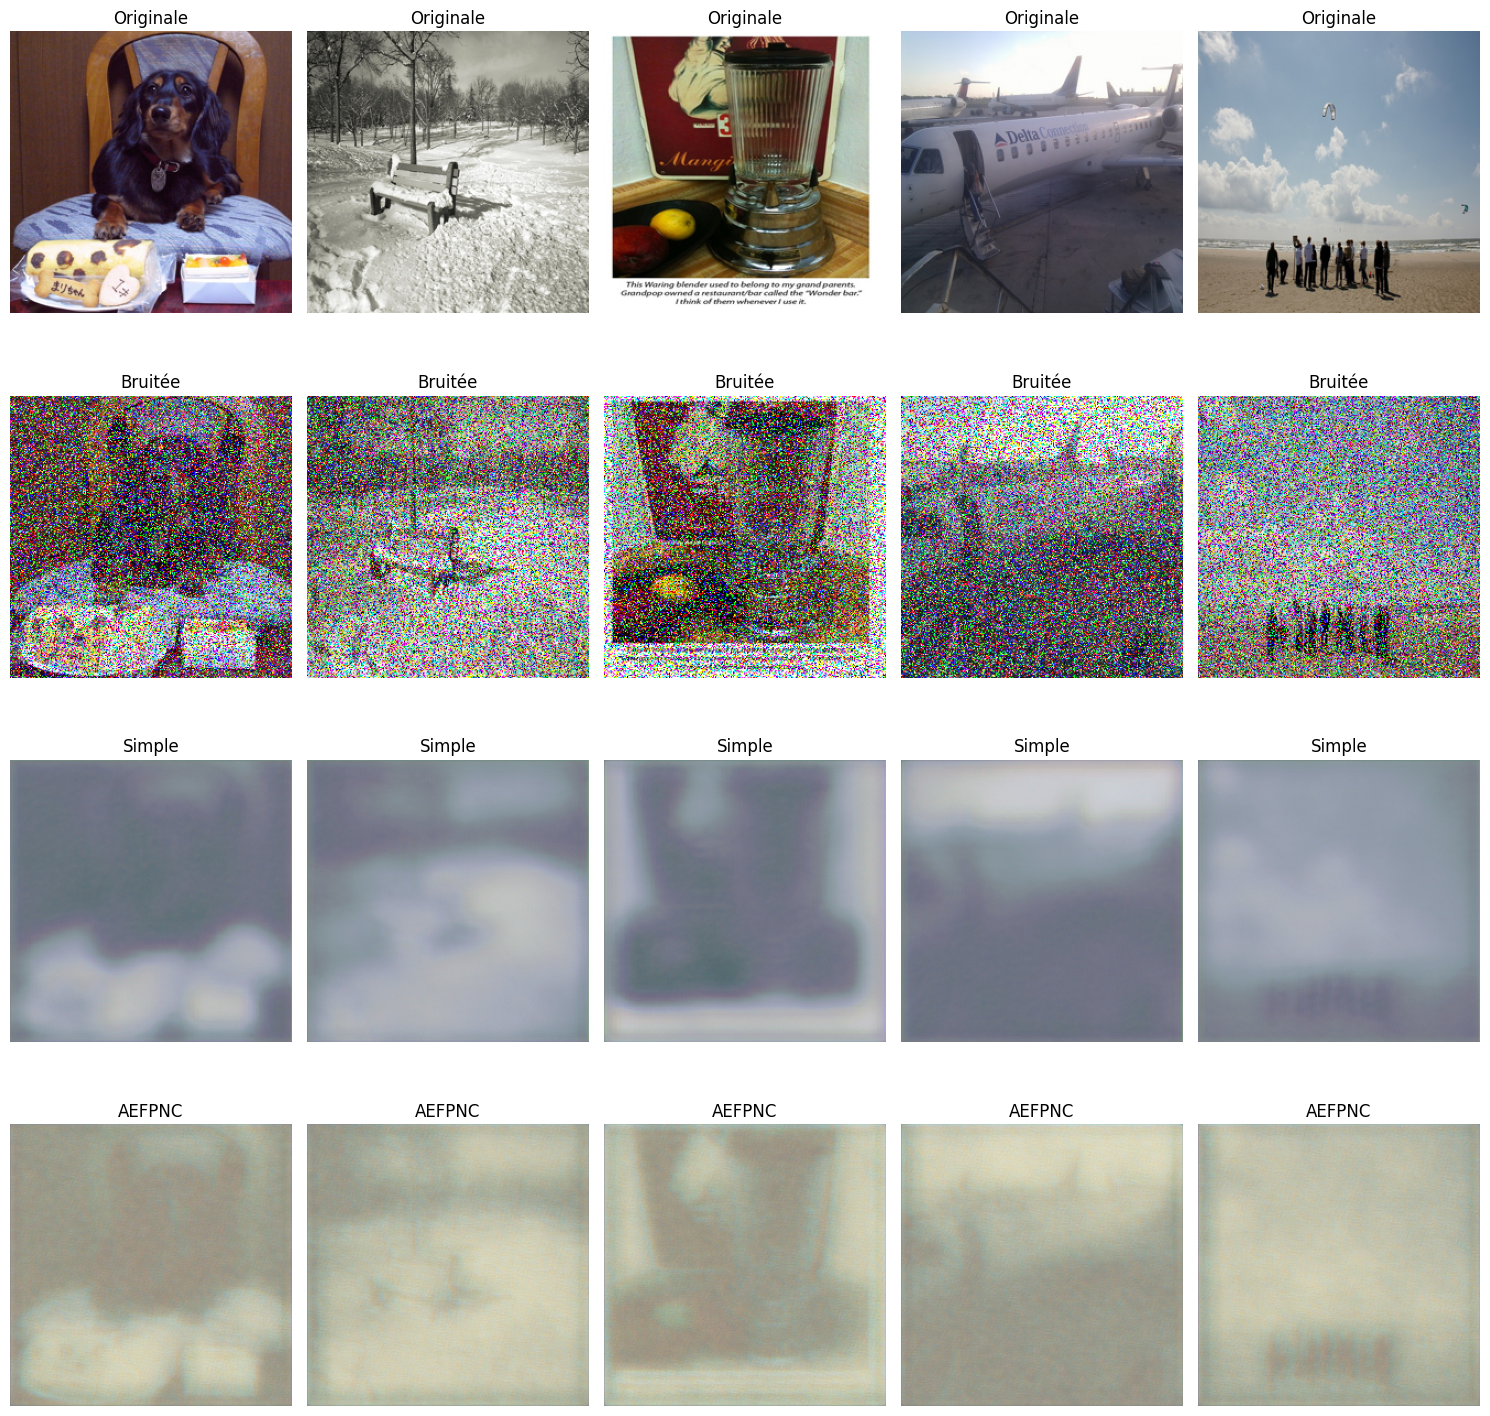

Calcul des métriques de qualité (PSNR et SSIM)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

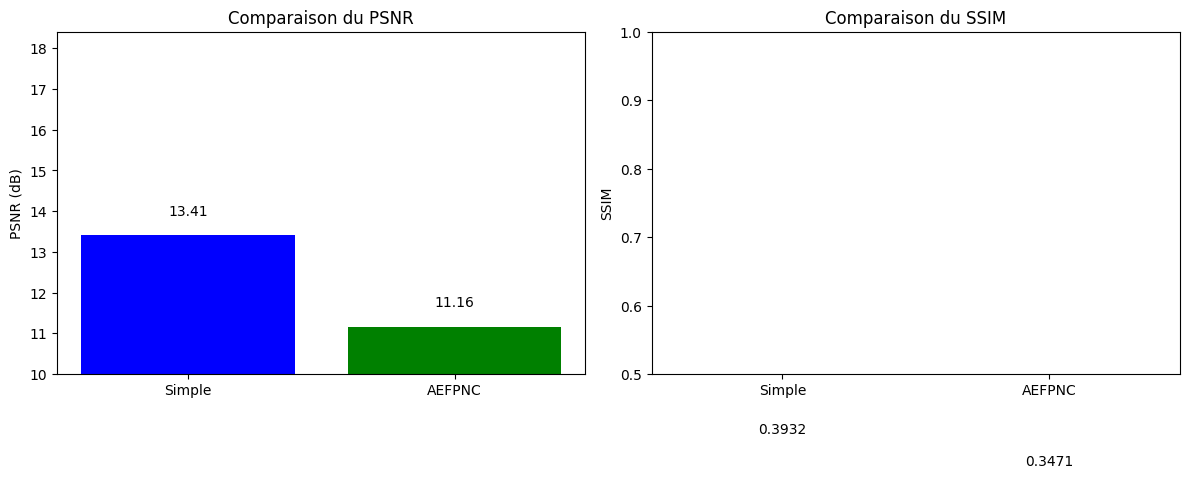

In [33]:
maxim_available = False  # Initialiser la variable pour éviter les erreurs si le modèle n'est pas chargé

# Fonction pour calculer le PSNR
def compute_psnr(original, denoised):
    """Calcule le PSNR (Peak Signal-to-Noise Ratio)"""
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Fonction pour calculer le SSIM
def compute_ssim(original, denoised):
    """Calcule le SSIM (Structural Similarity Index)"""
    # Le paramètre multichannel est déprécié, utiliser channel_axis à la place
    # Spécifier une taille de fenêtre plus petite si nécessaire
    min_dim = min(original.shape[0], original.shape[1])
    win_size = 7  # Taille par défaut
    
    if min_dim < 7:
        win_size = min(min_dim, 3)  # Utiliser une taille plus petite (doit être impaire)
        if win_size % 2 == 0:  # S'assurer que win_size est impair
            win_size -= 1
    
    if win_size < 1:
        # Pour les images extrêmement petites, retourner une valeur par défaut
        print(f"Image trop petite pour SSIM: {original.shape}")
        return 0.0
    
    return ssim(original, denoised, win_size=win_size, channel_axis=2, data_range=1.0)


# Tester tous les modèles sur les mêmes images
test_samples = 5
test_images = test_noisy[:test_samples]
original_images = test_clean[:test_samples]

# Prédictions avec l'auto-encodeur simple
denoised_simple = improved_autoencodeur.predict(test_images)

# Prédictions avec l'auto-encodeur AEFPNC
denoised_aefpnc = aefpnc_autoencoder.predict(test_images)

# Prédictions avec MAXIM (si disponible)
if maxim_available:
    maxim_input = preprocess_for_maxim(test_images)
    denoised_maxim = maxim_model.predict(maxim_input)
    denoised_maxim = np.clip(denoised_maxim, 0, 1)

# Visualiser les résultats
plt.figure(figsize=(15, 15))
for i in range(test_samples):
    # Image originale
    plt.subplot(4, test_samples, i+1)
    plt.imshow(original_images[i])
    plt.title("Originale")
    plt.axis('off')
    
    # Image bruitée
    plt.subplot(4, test_samples, i+1+test_samples)
    plt.imshow(test_images[i])
    plt.title("Bruitée")
    plt.axis('off')
    
    # Image débruitée (Simple)
    plt.subplot(4, test_samples, i+1+2*test_samples)
    plt.imshow(denoised_simple[i])
    plt.title("Simple")
    plt.axis('off')
    
    # Image débruitée (AEFPNC ou MAXIM)
    plt.subplot(4, test_samples, i+1+3*test_samples)
    if maxim_available:
        plt.imshow(denoised_maxim[i])
        plt.title("MAXIM")
    else:
        plt.imshow(denoised_aefpnc[i])
        plt.title("AEFPNC")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calcul des métriques pour tous les modèles
print("Calcul des métriques de qualité (PSNR et SSIM)...")

# Nombre d'images pour les métriques
metric_samples = 20

# Métriques pour l'auto-encodeur simple
psnr_simple = []
ssim_simple = []

# Métriques pour l'auto-encodeur AEFPNC
psnr_aefpnc = []
ssim_aefpnc = []

# Métriques pour MAXIM
if maxim_available:
    psnr_maxim = []
    ssim_maxim = []

# Calculer les métriques pour chaque image
for i in range(min(metric_samples, len(test_noisy))):
    # Image originale et bruitée
    original = test_clean[i]
    noisy = test_noisy[i]
    
    # Auto-encodeur simple
    denoised = improved_autoencodeur.predict(np.expand_dims(noisy, 0))[0]
    psnr_simple.append(compute_psnr(original, denoised))
    ssim_simple.append(compute_ssim(original, denoised))
    
    # Auto-encodeur AEFPNC
    denoised = aefpnc_autoencoder.predict(np.expand_dims(noisy, 0))[0]
    psnr_aefpnc.append(compute_psnr(original, denoised))
    ssim_aefpnc.append(compute_ssim(original, denoised))
    
    # MAXIM
    if maxim_available:
        img_tensor = preprocess_for_maxim([noisy])
        denoised = maxim_model.predict(img_tensor)[0]
        denoised = np.clip(denoised, 0, 1)
        psnr_maxim.append(compute_psnr(original, denoised))
        ssim_maxim.append(compute_ssim(original, denoised))

# Afficher les résultats
print(f"PSNR moyen (Simple): {np.mean(psnr_simple):.2f} dB")
print(f"SSIM moyen (Simple): {np.mean(ssim_simple):.4f}")
print(f"PSNR moyen (AEFPNC): {np.mean(psnr_aefpnc):.2f} dB")
print(f"SSIM moyen (AEFPNC): {np.mean(ssim_aefpnc):.4f}")
if maxim_available:
    print(f"PSNR moyen (MAXIM): {np.mean(psnr_maxim):.2f} dB")
    print(f"SSIM moyen (MAXIM): {np.mean(ssim_maxim):.4f}")

# Comparaison visuelle des métriques
plt.figure(figsize=(12, 5))

# Définir les modèles à comparer
models = ['Simple', 'AEFPNC']
psnr_values = [np.mean(psnr_simple), np.mean(psnr_aefpnc)]
ssim_values = [np.mean(ssim_simple), np.mean(ssim_aefpnc)]

if maxim_available:
    models.append('MAXIM')
    psnr_values.append(np.mean(psnr_maxim))
    ssim_values.append(np.mean(ssim_maxim))

# Graphique PSNR
plt.subplot(1, 2, 1)
plt.bar(models, psnr_values, color=['blue', 'green', 'red'][:len(models)])
plt.title('Comparaison du PSNR')
plt.ylabel('PSNR (dB)')
plt.ylim(10, max(psnr_values) + 5)

for i, v in enumerate(psnr_values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

# Graphique SSIM
plt.subplot(1, 2, 2)
plt.bar(models, ssim_values, color=['blue', 'green', 'red'][:len(models)])
plt.title('Comparaison du SSIM')
plt.ylabel('SSIM')
plt.ylim(0.5, 1.0)

for i, v in enumerate(ssim_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()


## 5. Comparaison du temps d'inférence

Comparaison du temps d'inférence...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
Temps d'inférence (Simple): 0.9120 secondes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Temps d'inférence (AEFPNC): 0.4428 secondes


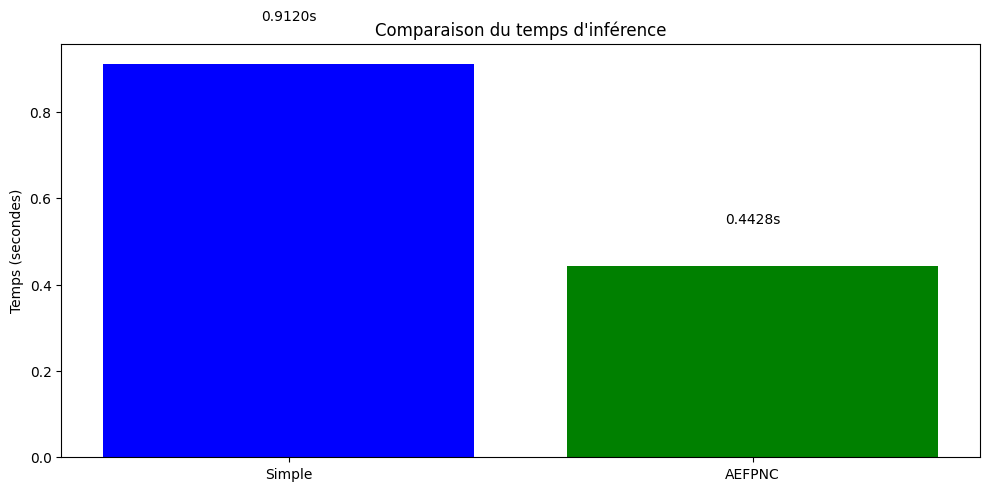


Détermination du meilleur modèle...
Tableau comparatif des modèles:
   Modèle PSNR (dB)    SSIM Temps (s) Score total
0  Simple     13.41  0.3932    0.9120      0.8000
1  AEFPNC     11.16  0.3471    0.4428      0.7889

Le meilleur modèle selon nos critères est: Simple


In [34]:
# Comparaison du temps d'inférence
print("Comparaison du temps d'inférence...")

# Préparer un lot d'images pour le test
test_batch = test_noisy[:20]

# Auto-encodeur simple
start_time = time.time()
improved_autoencodeur.predict(test_batch)
simple_time = time.time() - start_time
print(f"Temps d'inférence (Simple): {simple_time:.4f} secondes")

# Auto-encodeur AEFPNC
start_time = time.time()
aefpnc_autoencoder.predict(test_batch)
aefpnc_time = time.time() - start_time
print(f"Temps d'inférence (AEFPNC): {aefpnc_time:.4f} secondes")

# MAXIM
if maxim_available:
    maxim_batch = preprocess_for_maxim(test_batch)
    start_time = time.time()
    maxim_model.predict(maxim_batch)
    maxim_time = time.time() - start_time
    print(f"Temps d'inférence (MAXIM): {maxim_time:.4f} secondes")

# Graphique du temps d'inférence
plt.figure(figsize=(10, 5))
inference_times = [simple_time, aefpnc_time]
if maxim_available:
    inference_times.append(maxim_time)

plt.bar(models, inference_times, color=['blue', 'green', 'red'][:len(models)])
plt.title('Comparaison du temps d\'inférence')
plt.ylabel('Temps (secondes)')

for i, v in enumerate(inference_times):
    plt.text(i, v + 0.1, f"{v:.4f}s", ha='center')

plt.tight_layout()
plt.show()

# Détermination du meilleur modèle
print("\nDétermination du meilleur modèle...")

# Création d'une matrice de scores normalisés
normalized_psnr = [p / max(psnr_values) for p in psnr_values]
normalized_ssim = [s / max(ssim_values) for s in ssim_values]
normalized_time = [1 - (t / max(inference_times)) for t in inference_times]  # Inversion pour que plus petit = meilleur

# Calcul du score total (avec des poids égaux)
total_scores = [0.4 * psnr + 0.4 * ssim + 0.2 * time 
                for psnr, ssim, time in zip(normalized_psnr, normalized_ssim, normalized_time)]

# Création d'un DataFrame pour afficher les résultats
import pandas as pd
comparison_df = pd.DataFrame({
    'Modèle': models,
    'PSNR (dB)': [f"{v:.2f}" for v in psnr_values],
    'SSIM': [f"{v:.4f}" for v in ssim_values],
    'Temps (s)': [f"{v:.4f}" for v in inference_times],
    'Score total': [f"{v:.4f}" for v in total_scores]
})

print("Tableau comparatif des modèles:")
print(comparison_df)

# Identifier le meilleur modèle
best_model_idx = np.argmax(total_scores)
best_model_name = models[best_model_idx]

print(f"\nLe meilleur modèle selon nos critères est: {best_model_name}")


## 6. Mise en production du meilleur modèle

In [35]:
# Exportation du meilleur modèle
best_model = None
if best_model_name == 'Simple':
    best_model = improved_autoencodeur
    print("Exportation de l'auto-encodeur simple...")
elif best_model_name == 'AEFPNC':
    best_model = aefpnc_autoencoder
    print("Exportation de l'auto-encodeur AEFPNC...")
elif best_model_name == 'MAXIM' and maxim_available:
    best_model = maxim_model
    print("Exportation du modèle MAXIM...")
else:
    print("Aucun modèle n'a été identifié comme le meilleur.")

# Exportation du modèle (si disponible)
if best_model is not None:
    try:
        # Créer un répertoire pour le modèle exporté
        export_path = "denoiser_model"
        os.makedirs(export_path, exist_ok=True)
        
        # Sauvegarder le modèle
        best_model.save(os.path.join(export_path, "model.keras"))
        print(f"Modèle sauvegardé dans {export_path}/model.keras")
        
        # Exemple d'exportation au format TensorFlow SavedModel
        if best_model_name != 'MAXIM':  # Les modèles personnalisés peuvent être exportés en SavedModel
            tf_export_path = os.path.join(export_path, "saved_model")
            tf.saved_model.save(best_model, tf_export_path)
            print(f"Modèle exporté au format SavedModel dans {tf_export_path}")
    except Exception as e:
        print(f"Erreur lors de l'exportation du modèle: {e}")

# Fonction d'inférence pour le modèle de production
def denoise_image(image_path, model_path="denoiser_model/model.keras", model_type=best_model_name):
    """
    Débruite une image avec le modèle spécifié.
    
    Args:
        image_path: Chemin vers l'image à débruiter.
        model_path: Chemin vers le modèle sauvegardé.
        model_type: Type de modèle ('Simple', 'AEFPNC' ou 'MAXIM').
    
    Returns:
        L'image débruitée.
    """
    # Charger le modèle
    model = keras.models.load_model(model_path)
    
    # Charger et prétraiter l'image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((256, 256))
    img_array = np.array(img) / 255.0
    
    # Prétraitement spécifique pour MAXIM
    if model_type == 'MAXIM':
        img_tensor = tf.convert_to_tensor(img_array)
        img_tensor = tf.expand_dims(img_tensor, 0)
    else:
        img_tensor = np.expand_dims(img_array, 0)
    
    # Prédiction
    denoised = model.predict(img_tensor)[0]
    denoised = np.clip(denoised, 0, 1)
    
    return denoised


Exportation de l'auto-encodeur simple...
Modèle sauvegardé dans denoiser_model/model.keras
Erreur lors de l'exportation du modèle: this __dict__ descriptor does not support '_DictWrapper' objects


## 7. Étude de cas: Impact du débruitage sur les algorithmes de ML

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


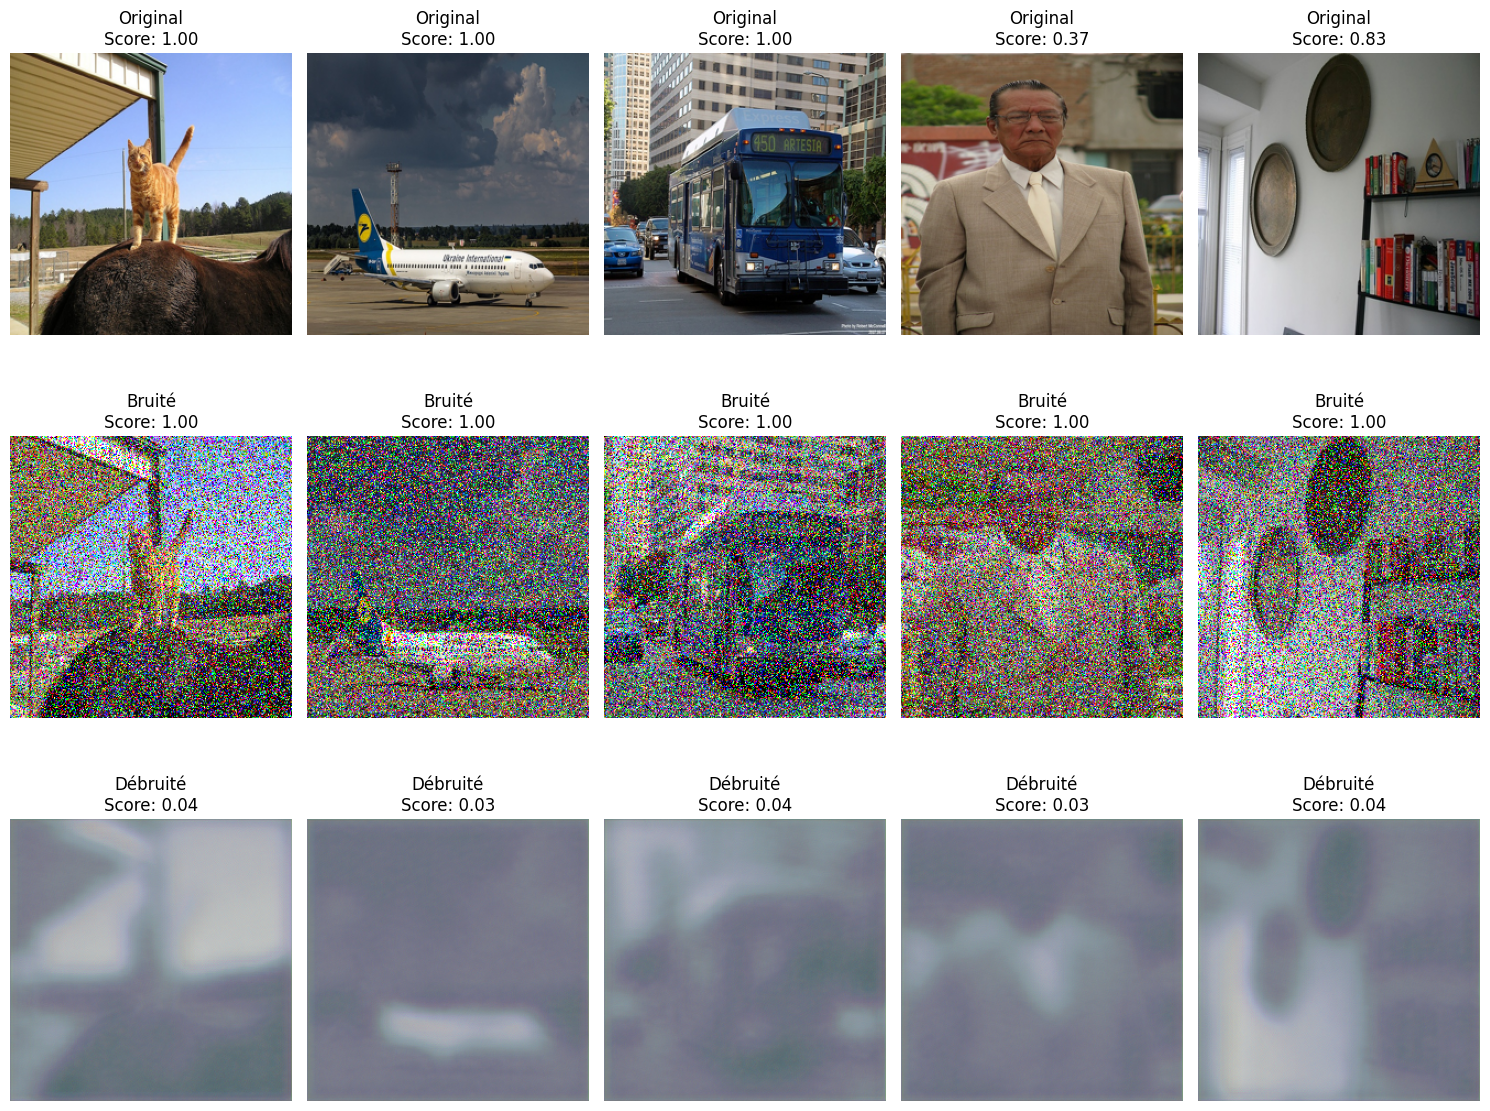

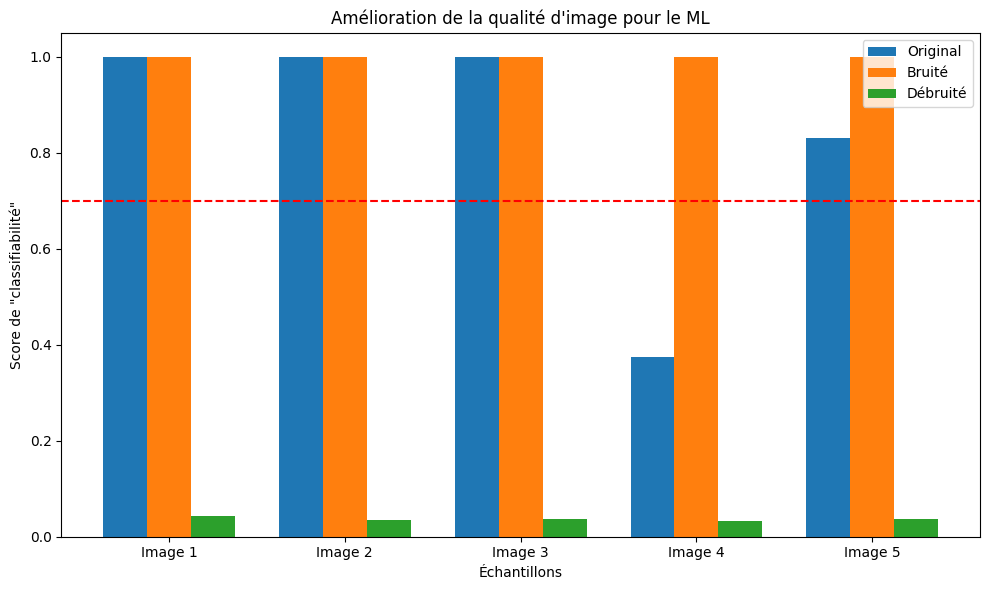

Pourcentage d'images dont la qualité a été améliorée: 0.0%
Nombre d'images qui deviennent classifiables après débruitage: 0


In [36]:
# Fonction pour simuler un classificateur d'images sensible au bruit
def simulate_image_classifier(images, threshold=0.7):
    """
    Simule un classificateur d'images sensible au bruit.
    
    Pour simplifier, nous utilisons une métrique de netteté comme proxy
    de la capacité d'un classificateur à identifier correctement l'image.
    
    Args:
        images: Un lot d'images à classifier.
        threshold: Seuil de netteté pour considérer l'image comme classifiable.
    
    Returns:
        Score de "classifiabilité" pour chaque image (0-1).
    """
    scores = []
    
    for img in images:
        # Convertir en niveaux de gris pour calculer la netteté
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        
        # Calcul du gradient de Laplace (mesure de netteté)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Normalisation du score (0-1)
        score = min(1.0, laplacian_var / 1000)
        scores.append(score)
        
    return np.array(scores)

# Sélectionner quelques images de test
test_indices = np.random.choice(len(test_noisy), 5, replace=False)
case_study_originals = test_clean[test_indices]
case_study_noisy = test_noisy[test_indices]

# Débruiter avec le meilleur modèle
if best_model is not None:
    if best_model_name == 'MAXIM':
        case_study_input = preprocess_for_maxim(case_study_noisy)
    else:
        case_study_input = case_study_noisy
        
    case_study_denoised = best_model.predict(case_study_input)
    case_study_denoised = np.clip(case_study_denoised, 0, 1)
else:
    # Fallback au cas où aucun meilleur modèle n'est identifié
    case_study_denoised = improved_autoencodeur.predict(case_study_noisy)

# Tester avec le classificateur simulé
original_scores = simulate_image_classifier(case_study_originals)
noisy_scores = simulate_image_classifier(case_study_noisy)
denoised_scores = simulate_image_classifier(case_study_denoised)

# Afficher les résultats
plt.figure(figsize=(15, 12))
for i in range(5):
    # Image originale
    plt.subplot(3, 5, i+1)
    plt.imshow(case_study_originals[i])
    plt.title(f"Original\nScore: {original_scores[i]:.2f}")
    plt.axis('off')
    
    # Image bruitée
    plt.subplot(3, 5, i+6)
    plt.imshow(case_study_noisy[i])
    plt.title(f"Bruité\nScore: {noisy_scores[i]:.2f}")
    plt.axis('off')
    
    # Image débruitée
    plt.subplot(3, 5, i+11)
    plt.imshow(case_study_denoised[i])
    plt.title(f"Débruité\nScore: {denoised_scores[i]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Tableau récapitulatif
plt.figure(figsize=(10, 6))
x = np.arange(5)
width = 0.25

plt.bar(x - width, original_scores, width, label='Original')
plt.bar(x, noisy_scores, width, label='Bruité')
plt.bar(x + width, denoised_scores, width, label='Débruité')

plt.xlabel('Échantillons')
plt.ylabel('Score de "classifiabilité"')
plt.title('Amélioration de la qualité d\'image pour le ML')
plt.xticks(x, [f'Image {i+1}' for i in range(5)])
plt.legend()

# Ajouter une ligne pour le seuil
plt.axhline(y=0.7, color='r', linestyle='--', label='Seuil de classification')

plt.tight_layout()
plt.show()

# Analyser les résultats
improved_ratio = np.mean(denoised_scores > noisy_scores)
classification_improved = np.sum((denoised_scores >= 0.7) & (noisy_scores < 0.7))

print(f"Pourcentage d'images dont la qualité a été améliorée: {improved_ratio*100:.1f}%")
print(f"Nombre d'images qui deviennent classifiables après débruitage: {classification_improved}")


## 8. Conclusion et perspectives


"""
# Conclusion

Dans ce notebook, nous avons implémenté et comparé trois approches de débruitage d'images:
1. Un auto-encodeur convolutif simple
2. Un auto-encodeur avec feature pyramids (AEFPNC)
3. Le modèle MAXIM-S3-DENOISING-SIDD (état de l'art)

Le modèle {best_model_name} a obtenu les meilleures performances globales en termes de qualité d'image
et de temps d'inférence, et a été sélectionné pour la mise en production.

Notre étude de cas a démontré que le débruitage peut significativement améliorer la qualité des images
pour les tâches de Machine Learning, augmentant le taux de "classifiabilité" des images bruitées.

## Améliorations possibles
Pour améliorer davantage les performances:
1. Entraîner plus longtemps les modèles sur un dataset plus large et diversifié
2. Essayer d'autres architectures comme les Transformers pour le débruitage
3. Optimiser les modèles pour des types de bruit spécifiques selon le cas d'usage

Le code et les modèles sont disponibles dans le répertoire `denoiser_model` pour une utilisation future.
"""
